In [9]:
from __future__ import annotations

from time import time

import matplotlib.pyplot as plt
import numpy as np
from multinterp.curvilinear import Curvilinear2DInterp, Warped2DInterp

Suppose we have a collection of values for an unknown function along with their respective coordinate points. For illustration, assume the values come from the following function:


In [10]:
def function_1(x, y):
    return x * (1 - x) * np.cos(4 * np.pi * x) * np.sin(4 * np.pi * y**2) ** 2

The points are randomly scattered in the unit square and therefore have no regular structure. This is achieved by randomly shifting a well structured grid at every point. 


In [11]:
rng = np.random.default_rng(0)
warp_factor = 0.01
x_list = np.linspace(0, 1, 20)
y_list = np.linspace(0, 1, 20)
x_temp, y_temp = np.meshgrid(x_list, y_list, indexing="ij")
rand_x = x_temp + warp_factor * (rng.random((x_list.size, y_list.size)) - 0.5)
rand_y = y_temp + warp_factor * (rng.random((x_list.size, y_list.size)) - 0.5)
values = function_1(rand_x, rand_y)

Now suppose we would like to interpolate this function on a rectilinear grid, which is known as "regridding".


In [12]:
grid_x, grid_y = np.meshgrid(
    np.linspace(0, 1, 100),
    np.linspace(0, 1, 100),
    indexing="ij",
)

To do this, we use `multinterp`'s `Warped2DInterp` and `Curvilinear2DInterp` classes. The class takes the following arguments:

- `values`: an ND-array of values for the function at the points
- `grids`: a list of ND-arrays of coordinates for the points
- `backend`: the backend to use for interpolation, currently only `scipy` and `numba` are supported for `Warped2DInterp` and only `scipy` is supported for `Curvilinear2DInterp`


In [13]:
warped_interp = Warped2DInterp(values, (rand_x, rand_y), backend="numba")
warped_interp.warmup()

Once we create the interpolator objects, we can evaluate the functions on the query grids and compare their time performance.


In [14]:
start = time()
warped_grid = warped_interp(grid_x, grid_y)
print(f"Warped interpolation took {time() - start:.5f} seconds")

Warped interpolation took 0.00240 seconds


In [15]:
curvilinear_interp = Curvilinear2DInterp(values, (rand_x, rand_y))
start = time()
curvilinear_grid = curvilinear_interp(grid_x, grid_y)
print(f"Curvilinear interpolation took {time() - start:.5f} seconds")

Curvilinear interpolation took 0.00802 seconds


Now we can compare the results of the interpolation with the original function. Below we plot the original function and the sample points that are known. Notice that the points are almost rectilinear, but have been randomly shifted to create a more challenging interpolation problem.


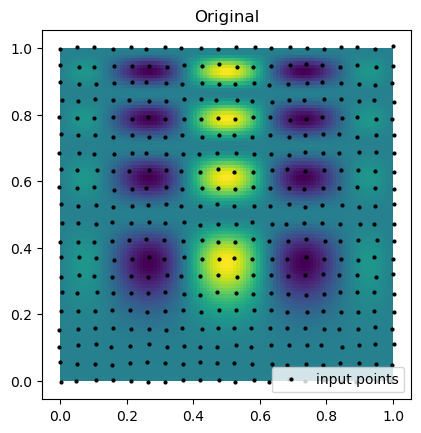

In [16]:
plt.imshow(function_1(grid_x, grid_y).T, extent=(0, 1, 0, 1), origin="lower")
plt.plot(rand_x.flat, rand_y.flat, "ok", ms=2, label="input points")
plt.title("Original")
plt.legend(loc="lower right")

Then, we can look at the result for each method of interpolation and compare it to the original function.


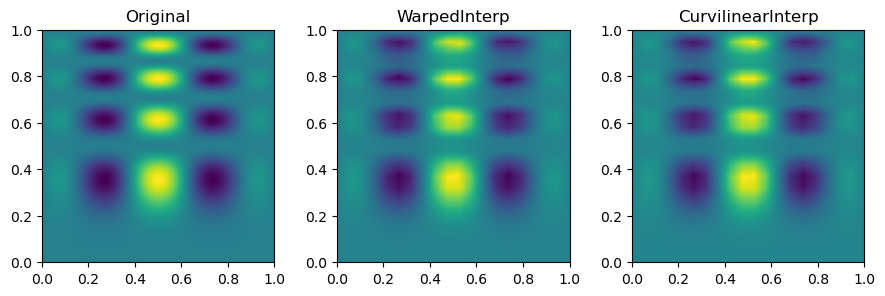

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(9, 6))
titles = ["Original", "WarpedInterp", "CurvilinearInterp"]
grids = [function_1(grid_x, grid_y), warped_grid, curvilinear_grid]

for ax, title, grid in zip(axs.flat, titles, grids):
    im = ax.imshow(grid.T, extent=(0, 1, 0, 1), origin="lower")
    ax.set_title(title)

plt.tight_layout()
plt.show()

In short, `multinterp`'s `Warped2DInterp` and `Curvilinear2DInterp` classes are useful for interpolating functions on curvilinear grids which have a quadrilateral structure but are not perfectly rectangular. 